# Trabalho Prático 01 - IA_24/25

## Autores:
- Nuno Castro_4944  
- Jorge Mendes_18466  
- André Freitas_25975  

### Data: 23 de Novembro de 2024

Este trabalho foi desenvolvido no âmbito da unidade curricular de Inteligência Artificial, com o objetivo de aplicar técnicas de resolução de problemas e otimização em projetos de agendamento de tarefas. O foco principal consistiu na utilização de um solver de restrições para planear um conjunto de tarefas interdependentes, respeitando restrições de precedência e recursos limitados, e na análise das soluções obtidas.

O objetivo principal foi criar um programa capaz de:

- Interpretar ficheiros com os dados do projeto (tarefas, recursos, relações de precedência).  
- Calcular e apresentar soluções, tentando minimizar o tempo total do projeto (**makespan**).  
- Destacar o **caminho crítico** e visualizá-lo através de um **diagrama de Gantt**.  


### Definição do Objetivo, Possíveis Limitações e Ações a Realizar

- **Objetivo:**  
Desenvolver uma solução automatizada para agendar tarefas de um projeto, minimizando o tempo total de execução (**makespan**) e respeitando as restrições de precedência e os recursos disponíveis. Além disso, destacar o **caminho crítico** e visualizá-lo num **diagrama de Gantt**.

- **Possíveis Limitações:**  
  - Complexidade computacional em projetos de grande escala, o que pode impactar o desempenho do solver.  
  - Resultados dependentes da qualidade e precisão dos dados de entrada (tarefas, durações e recursos).  
  - Limitação do solver em encontrar múltiplas soluções em tempo viável para projetos muito restritivos.  

- **Ações a Realizar:**  
  1. Ler e interpretar os dados de entrada a partir de ficheiros predefinidos.  
  2. Calcular o agendamento das tarefas, gerando soluções que minimizem o **makespan**.  
  3. Identificar o **caminho crítico** e as tarefas que o compõem.  
  4. Apresentar as soluções e o caminho crítico num **diagrama de Gantt** para análise visual.  


In [ ]:
# Instalar biblioteca "Constraint"
!pip install python-constraint *


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 971.0/971.0 kB 10.4 MB/s eta 0:00:00
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2.py3-none-any.whl size=24059 sha256=5260c9286b69d9dc574d1342e0e1959ad3d7e494deefbc6b63800c79f767a1ce
  Stored in directory: /root/.cache/pip/wheels/2e/f2/2b/cb08b5fe129e4f69b7033061f256e5c551b0aa1160c2872aee
Successfully built python-constraint


In [ ]:
# Importar bibliotecas
from constraint import *
from google.colab import files

In [ ]:
# Carregar o ficheiro
uploaded = files.upload()

for fn in uploaded.keys():

    file_path = "/content/" + fn

    with open(file_path, "wb") as f:
        f.write(uploaded[fn])

Saving P01 DataSet-10.txt to P01 DataSet-10 (3).txt


In [ ]:
# Realização do parser do ficheiro introduzido

def parse_project_file(file_path):
    # Estrutura para armazenar os dados extraídos
    data = {
        'general_info': {},
        'project_summary': {},
        'precedence_relations': [],
        'duration_and_resources': [],
        'resource_availability': {}
    }
    current_section = None

    # Abre o ficheiro para leitura
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove espaços em branco no início e no fim

            # Ignorar linhas de separadores
            if line.startswith("*"):
                current_section = None  # Repor a secção ao encontrar um separador
                continue

            # Identificar o início das secções
            if line.startswith("projects"):
                current_section = 'general_info'
                print("Secção 'General Information' iniciada.")  # Ponto de verificação
                continue
            elif line.startswith("pronr."):
                current_section = 'project_summary'
                print("Secção 'Projects Summary' iniciada.")  # Ponto de verificação
                continue  # Evita o cabeçalho
            elif line.startswith("#jobnr.") and "#modes" in line:
                current_section = 'precedence_relations'
                print("Secção 'Precedence Relations' iniciada.")  # Ponto de verificação
                continue  # Evita o cabeçalho
            elif line.startswith("#jobnr.") and "mode" in line:
                current_section = 'duration_and_resources'
                print("Secção 'Duration and Resources' iniciada.")  # Ponto de verificação
                continue  # Evita o cabeçalho
            elif line.startswith("#resource"):
                current_section = 'resource_availability'
                print("Secção 'Resource Availability' iniciada.")  # Ponto de verificação
                continue

            # Processar 'General Information'
            if current_section == 'general_info':
                if "projects" in line:
                    try:
                        data['general_info']['projects'] = int(line.split(":")[1].strip())
                    except ValueError as e:
                        print(f"Erro ao processar 'projects': {line}. Erro: {e}")
                elif "jobs" in line:
                    try:
                        data['general_info']['jobs'] = int(line.split(":")[1].strip().split()[0])
                    except ValueError as e:
                        print(f"Erro ao processar 'jobs': {line}. Erro: {e}")
                elif "horizon" in line:
                    try:
                        data['general_info']['horizon'] = int(line.split(":")[1].strip())
                    except ValueError as e:
                        print(f"Erro ao processar 'horizon': {line}. Erro: {e}")
                elif line.startswith("RESOURCES"):
                    current_section = None

            # Processar 'Projects Summary'
            elif current_section == 'project_summary':
                parts = line.split()
                if len(parts) == 6 and all(p.isdigit() for p in parts):
                    try:
                        data['project_summary'] = {
                            'project_number': int(parts[0]),
                            'num_jobs': int(parts[1]),
                            'release_date': int(parts[2]),
                            'due_date': int(parts[3]),
                            'tardiness_cost': int(parts[4]),
                            'mpm_time': int(parts[5])
                        }
                        print("Dados da secção 'Projects Summary' capturados.")  # Ponto de verificação
                    except ValueError as e:
                        print(f"Erro ao processar linha em 'Projects Summary': {line}. Erro: {e}")
                    current_section = None

            # Processar 'Precedence Relations'
            elif current_section == 'precedence_relations':
                parts = line.split()
                if len(parts) >= 3:
                    try:
                        job_number = int(parts[0])
                        num_successors = int(parts[2])
                        successors = list(map(int, parts[3:3 + num_successors]))
                        data['precedence_relations'].append({
                            'job': job_number,
                            'successors': successors
                        })
                    except ValueError as e:
                        print(f"Erro ao processar linha em 'Precedence Relations': {line}. Erro: {e}")

            # Processar 'Duration and Resources'
            elif current_section == 'duration_and_resources':
                parts = line.split()
                if len(parts) == 5:
                    try:
                        job_number = int(parts[0])
                        duration = int(parts[2])
                        r1 = int(parts[3])
                        r2 = int(parts[4])
                        data['duration_and_resources'].append({
                            'job': job_number,
                            'duration': duration,
                            'R1': r1,
                            'R2': r2
                        })
                    except ValueError as e:
                        print(f"Erro ao processar linha em 'Duration and Resources': {line}. Erro: {e}")

            # Processar 'Resource Availability'
            elif current_section == 'resource_availability':
                parts = line.split()
                if len(parts) == 2:
                    try:
                        resource = parts[0]
                        qty = int(parts[1])
                        data['resource_availability'][resource] = qty
                    except ValueError as e:
                        print(f"Erro ao processar linha em 'Resource Availability': {line}. Erro: {e}")

    # Mostrar conteúdo extraído
    print("\nConteúdo extraído:")
    for section, content in data.items():
        print(f"\nSecção: {section}")
        if isinstance(content, dict):
            for key, value in content.items():
                print(f"  {key}: {value}")
        elif isinstance(content, list):
            for item in content:
                print(f"  {item}")

    return data

# Chamar a função
parsed_data = parse_project_file(file_path)  # O caminho do ficheiro é a variável anterior


Secção 'General Information' iniciada.
Secção 'Projects Summary' iniciada.
Dados da secção 'Projects Summary' capturados.
Secção 'Precedence Relations' iniciada.
Secção 'Duration and Resources' iniciada.
Secção 'Resource Availability' iniciada.

Conteúdo extraído:

Secção: general_info
  jobs: 12
  horizon: 46

Secção: project_summary
  project_number: 1
  num_jobs: 10
  release_date: 0
  due_date: 21
  tardiness_cost: 3
  mpm_time: 21

Secção: precedence_relations
  {'job': 1, 'successors': [2, 3, 4]}
  {'job': 2, 'successors': [5, 6]}
  {'job': 3, 'successors': [10, 11]}
  {'job': 4, 'successors': [9]}
  {'job': 5, 'successors': [7, 8]}
  {'job': 6, 'successors': [10, 11]}
  {'job': 7, 'successors': [9, 10]}
  {'job': 8, 'successors': [9]}
  {'job': 9, 'successors': [12]}
  {'job': 10, 'successors': [12]}
  {'job': 11, 'successors': [12]}
  {'job': 12, 'successors': []}

Secção: duration_and_resources
  {'job': 1, 'duration': 0, 'R1': 0, 'R2': 0}
  {'job': 2, 'duration': 3, 'R1': 6, 

### Contextualização do Código

A função `calculate_domains` foi criada para calcular os intervalos de tempo em que cada tarefa pode começar, respeitando as relações de precedência entre tarefas e o tempo máximo do projeto (**mpm_time**).

A função calcula, para cada tarefa:
- O **tempo mínimo de início**, com base no término das tarefas anteriores (antecessores).
- O **tempo máximo de início**, garantindo que a tarefa termine antes do tempo limite do projeto.

Estes intervalos, chamados de domínios, são apresentados no final e serão usados pelo solver de restrições para encontrar soluções que minimizem o tempo total do projeto.


In [ ]:
def calculate_domains(parsed_data):
    # Obter informações gerais
    jobs = parsed_data['general_info']['jobs']
    mpm_time = parsed_data['project_summary']['mpm_time']
    precedence_relations = parsed_data['precedence_relations']
    durations = {entry['job']: entry['duration'] for entry in parsed_data['duration_and_resources']}

    # Criar um dicionário de antecessores
    predecessors = {job: [] for job in range(1, jobs + 1)}
    for relation in precedence_relations:
        job = relation['job']
        for successor in relation['successors']:
            predecessors[successor].append(job)

    # Inicializar os domínios ajustados
    domains = {}
    for job in range(1, jobs + 1):
        # Calcular o tempo mínimo com base no término dos antecessores
        if predecessors[job]:
            min_start_time = max([domains[pre][0] + durations[pre] for pre in predecessors[job]])
        else:
            min_start_time = 1  # O tempo inicial foi ajustado para começar em 1

        # Calcular o tempo máximo com base no horizonte do projeto (mpm_time)
        max_start_time = mpm_time - durations[job]

        # Ajustar o domínio
        domains[job] = [min_start_time, max_start_time]

    # Exibir os resultados no formato solicitado
    for job, domain in domains.items():
        print(f"Job {job}: Domínio = {domain}")

    return domains

# Chamar a função para calcular os domínios
domains = calculate_domains(parsed_data)


Job 1: Domínio = [1, 21]
Job 2: Domínio = [1, 18]
Job 3: Domínio = [1, 20]
Job 4: Domínio = [1, 13]
Job 5: Domínio = [4, 17]
Job 6: Domínio = [4, 17]
Job 7: Domínio = [8, 15]
Job 8: Domínio = [8, 17]
Job 9: Domínio = [14, 16]
Job 10: Domínio = [14, 14]
Job 11: Domínio = [8, 17]
Job 12: Domínio = [21, 21]


### Contextualização do Código

A função `solve_project_schedule_with_constraints` resolve o planeamento de projetos, garantindo que as tarefas cumpram as restrições de precedência e os limites de recursos. O objetivo é encontrar os tempos de início de cada tarefa para minimizar o tempo total do projeto

O processo é dividido em várias etapas:
1. **Cálculo dos Domínios:** Define os intervalos possíveis de início para cada tarefa, considerando as relações de precedência e a duração do projeto.
2. **Criação de Variáveis:** Cria variáveis no solver com os domínios calculados.
3. **Adição de Restrições de Precedência:** Assegura que as tarefas sucessoras só comecem após o término das suas predecessoras.
4. **Adição de Restrições de Recursos:** Garante que os recursos disponíveis não sejam excedidos em nenhum momento.
5. **Resolução do Problema:** Utiliza o solver para encontrar uma solução viável, listando os tempos de início de cada tarefa.

Por fim, a solução é formatada e apresentada de forma ordenada para facilitar a análise e validação do plano de execução.


In [ ]:
def solve_project_schedule_with_constraints(parsed_data):
    """
    Resolve o problema de agendamento do projeto com restrições de precedência e recursos.
    """
    print("[INFO] A iniciar o solver para o agendamento do projeto...\n")

    # Inicializar o solver
    problem = Problem()

    # 1. Calcular os domínios das tarefas
    adjusted_task_domains = calculate_domains(parsed_data)

    # 2. Criar variáveis no solver com os domínios calculados
    start_vars = {}
    for job, domain in adjusted_task_domains.items():
        start_var = f"start_{job}"
        start_vars[job] = start_var
        problem.addVariable(start_var, range(domain[0], domain[1] + 1))

    # 3. Adicionar restrições de precedência
    def add_precedence_constraints(problem, start_vars, jobs_data, precedence_data):
        # Para cada relação de precedência, adiciona uma restrição para garantir que os sucessores
        # comecem após os seus predecessores terminarem
        for relation in precedence_data:
            predecessor = relation['job']
            for successor in relation['successors']:
                problem.addConstraint(
                    lambda start_pre, start_suc, dur=jobs_data[predecessor - 1]['duration']: start_pre + dur <= start_suc,
                    (start_vars[predecessor], start_vars[successor])
                )

    # Chamar a função para adicionar as restrições de precedência
    add_precedence_constraints(problem, start_vars, parsed_data['duration_and_resources'], parsed_data['precedence_relations'])

    # 4. Adicionar restrições de recursos
    def add_resource_constraints(problem, start_vars, jobs_data, resource_limits, horizon):
        def resource_constraint(*args):
            # Verificar se a utilização dos recursos em qualquer momento excede os limites
            times = list(args)
            resource_usage = {r: [0] * (horizon + 1) for r in resource_limits.keys()}

            for t in range(horizon + 1):
                usage = {r: 0 for r in resource_limits.keys()}
                for i, start in enumerate(times):
                    if start <= t < start + jobs_data[i]['duration']:
                        for r in resource_limits.keys():
                            usage[r] += jobs_data[i][r]
                # Se exceder o limite de qualquer recurso, retorna False
                if any(usage[r] > resource_limits[r] for r in resource_limits.keys()):
                    return False
            return True

        # Adicionar a restrição de utilização dos recursos ao solver
        problem.addConstraint(resource_constraint, list(start_vars.values()))

    # Chamar a função para adicionar as restrições de recursos
    add_resource_constraints(problem, start_vars, parsed_data['duration_and_resources'], parsed_data['resource_availability'], parsed_data['general_info']['horizon'])

    # 5. Resolver o problema
    print("[INFO] A tentar resolver o problema...\n")
    solution = problem.getSolution()

    # 6. Exibir a solução por ordem dos jobs
    if solution:
        print("[SOLUÇÃO ENCONTRADA]")
        formatted_solution = {}
        # Reformata a solução para mapear os IDs dos jobs com os seus tempos de início
        for job_id, start_time in solution.items():
            task_id = int(job_id.replace("start_", ""))
            formatted_solution[task_id] = start_time

        # Ordenar e exibir a solução por ID dos jobs
        for task_id in sorted(formatted_solution.keys()):
            print(f"Tarefa {task_id}: Início no tempo {formatted_solution[task_id]}")

        return formatted_solution
    else:
        print("[ERRO] Nenhuma solução encontrada. Verifique as restrições.")
        return None

# Resolver o problema
formatted_solution = solve_project_schedule_with_constraints(parsed_data)


[INFO] A iniciar o solver para o agendamento do projeto...

Job 1: Domínio = [1, 21]
Job 2: Domínio = [1, 18]
Job 3: Domínio = [1, 20]
Job 4: Domínio = [1, 13]
Job 5: Domínio = [4, 17]
Job 6: Domínio = [4, 17]
Job 7: Domínio = [8, 15]
Job 8: Domínio = [8, 17]
Job 9: Domínio = [14, 16]
Job 10: Domínio = [14, 14]
Job 11: Domínio = [8, 17]
Job 12: Domínio = [21, 21]
[INFO] A tentar resolver o problema...

[SOLUÇÃO ENCONTRADA]
Tarefa 1: Início no tempo 1
Tarefa 2: Início no tempo 1
Tarefa 3: Início no tempo 13
Tarefa 4: Início no tempo 4
Tarefa 5: Início no tempo 4
Tarefa 6: Início no tempo 8
Tarefa 7: Início no tempo 8
Tarefa 8: Início no tempo 12
Tarefa 9: Início no tempo 16
Tarefa 10: Início no tempo 14
Tarefa 11: Início no tempo 17
Tarefa 12: Início no tempo 21


### Contextualização do Código

A função `find_critical_path` identifica o **caminho crítico** de um projeto com base na solução calculada pelo solver. O caminho crítico é composto pelas tarefas que determinam a duração total do projeto, ou seja, as que não podem ser atrasadas sem aumentar o tempo total.

A lógica da função é simples:
1. **Obter as Durações e Relações de Precedência:** São extraídas as durações de cada tarefa e as relações de precedência entre elas.
2. **Calcular os Tempos de Término:** Para cada tarefa, calcula-se o tempo de término, somando o tempo de início à sua duração.
3. **Identificar o Caminho Crítico:** Partindo da primeira tarefa, verifica-se quais sucessores iniciam imediatamente após o término da tarefa atual. Esse processo é repetido até identificar todas as tarefas que compõem o caminho crítico.

Por fim, o caminho crítico é exibido no terminal, permitindo uma análise clara das tarefas que têm maior impacto no tempo total do projeto.


In [ ]:
def find_critical_path(solution, parsed_data):
    """
    Encontra o caminho crítico a partir da solução obtida pelo solver.

    :param solution: Dicionário com os tempos de início de cada tarefa.
    :param parsed_data: Dicionário contendo as informações do projeto.
    :return: Lista com as tarefas que pertencem ao caminho crítico.
    """
    # Obter as durações das tarefas
    durations = {entry['job']: entry['duration'] for entry in parsed_data['duration_and_resources']}
    precedence_relations = parsed_data['precedence_relations']

    # Calcular os tempos de término para cada tarefa
    end_times = {job: solution[job] + durations[job] for job in solution.keys()}

    # Identificar as tarefas que pertencem ao caminho crítico
    critical_path = []
    current_task = 1  # Começar a partir da tarefa inicial
    while current_task is not None:
        critical_path.append(current_task)
        # Procurar sucessores no caminho crítico
        next_task = None
        for relation in precedence_relations:
            if relation['job'] == current_task:
                for successor in relation['successors']:
                    # Verificar se o sucessor começa imediatamente após o término da tarefa atual
                    if solution[successor] == end_times[current_task]:
                        next_task = successor
                        break
            if next_task:
                break
        current_task = next_task

    return critical_path

# Calcular o caminho crítico
critical_path = find_critical_path(formatted_solution, parsed_data)
print(f"\nCaminho Crítico: {critical_path}")



Caminho Crítico: [1, 2, 5, 7, 10, 12]


## Diagrama de Gantt

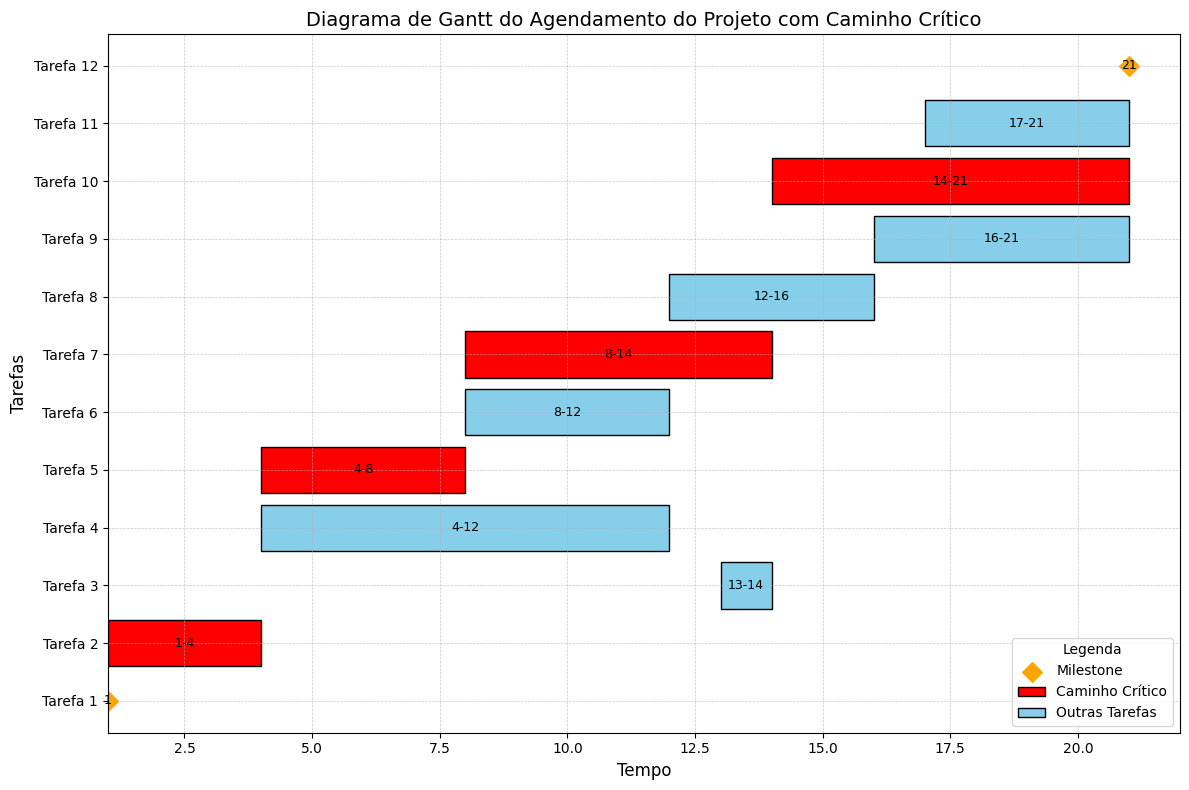

In [ ]:
import matplotlib.pyplot as plt

def generate_gantt_chart(solution, jobs_data, critical_path):
    """
    Gera um gráfico de Gantt com base na solução e nos dados das tarefas,
    destacando o caminho crítico e adicionando uma legenda.

    :param solution: Dicionário com os tempos de início para cada tarefa.
    :param jobs_data: Lista com informações das tarefas (duração e ID).
    :param critical_path: Lista de IDs das tarefas no caminho crítico.
    """
    if not solution:
        print("[ERRO] Nenhuma solução válida foi encontrada para gerar o gráfico.")
        return

    # Preparar os dados para o gráfico
    tasks = []
    milestones = []

    # Organizar os dados por ordem dos IDs das tarefas
    sorted_jobs_data = sorted(jobs_data, key=lambda job: job['job'])
    for job in sorted_jobs_data:
        job_id = job['job']
        if job_id in solution:
            start_time = solution[job_id]
            duration = job['duration']
            if duration == 0:  # Identificar milestones (tarefas com duração zero)
                milestones.append((f"Tarefa {job_id}", start_time, job_id))
            else:
                tasks.append((f"Tarefa {job_id}", start_time, duration, job_id))

    # Combinar milestones e tarefas numa única lista, mantendo a ordem dos IDs
    combined = tasks + [(m[0], m[1], 0, m[2]) for m in milestones]
    combined = sorted(combined, key=lambda x: int(x[0].split()[1]))  # Ordenar por ID da tarefa

    # Criar o gráfico
    fig, ax = plt.subplots(figsize=(12, 8))

    # Adicionar elementos ao gráfico
    for i, (task, start, duration, job_id) in enumerate(combined):
        if duration > 0:  # Tarefa regular
            color = "red" if job_id in critical_path else "skyblue"  # Destacar as tarefas críticas
            ax.barh(i, duration, left=start, color=color, edgecolor="black", label="Caminho Crítico" if job_id in critical_path else "Outras Tarefas")
            ax.text(
                start + duration / 2,
                i,
                f"{start}-{start + duration}",
                va="center",
                ha="center",
                color="black",
                fontsize=9
            )
        else:  # Milestone (tarefa com duração zero)
            color = "orange"  # Destacar milestones críticos
            ax.scatter(
                start, i, color=color, marker="D", s=100, label="Milestone"
            )
            ax.text(
                start,
                i,
                f"{start}",
                va="center",
                ha="center",
                color="black",
                fontsize=9
            )

    # Configurar o gráfico
    ax.set_yticks(range(len(combined)))
    ax.set_yticklabels([task[0] for task in combined])
    ax.set_xlabel("Tempo", fontsize=12)
    ax.set_ylabel("Tarefas", fontsize=12)
    ax.set_title("Diagrama de Gantt do Agendamento do Projeto com Caminho Crítico", fontsize=14)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    # Adicionar a legenda
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remover duplicados na legenda
    ax.legend(by_label.values(), by_label.keys(), loc="lower right", fontsize=10, title="Legenda")

    # Ajustar o layout para evitar sobreposições
    plt.tight_layout()
    plt.show()

# Exemplo de chamada para gerar o gráfico
generate_gantt_chart(formatted_solution, parsed_data['duration_and_resources'], critical_path)


### Contextualização do Código

Nesta versão da função, o solver calcula **múltiplas soluções viáveis** (até 5, por padrão) e escolhe a melhor com base no menor **makespan**, ou seja, o tempo total necessário para concluir o projeto.

A diferença principal nesta versão está na etapa de **Resolução do Problema**:
- O solver calcula várias soluções possíveis (limitadas a 5).
- Cada solução é avaliada com base no seu makespan.
- A solução com o menor makespan é selecionada e apresentada como a melhor.

Esta abordagem permite explorar múltiplas possibilidades e selecionar a mais eficiente, garantindo que o projeto seja concluído no menor tempo possível, respeitando todas as restrições.


In [ ]:
from constraint import Problem

def solve_project_schedule_with_constraints(parsed_data, num_solutions=5):
    """
    Resolve o problema de agendamento do projeto com restrições de precedência e recursos,
    apresentando múltiplas soluções e escolhendo a melhor com base no menor makespan.

    :param parsed_data: Dados do projeto.
    :param num_solutions: Número de soluções a calcular (por padrão: 5).
    :return: A melhor solução (com menor makespan).
    """
    print("[INFO] A iniciar o solver para o agendamento do projeto...\n")

    # Inicializar o solver
    problem = Problem()

    # 1. Calcular os domínios das tarefas
    adjusted_task_domains = calculate_domains(parsed_data)

    # 2. Criar variáveis no solver com os domínios calculados
    start_vars = {}
    for job, domain in adjusted_task_domains.items():
        start_var = f"start_{job}"
        start_vars[job] = start_var
        # Adicionar variáveis com o respetivo domínio (intervalo de tempos possíveis)
        problem.addVariable(start_var, range(domain[0], domain[1] + 1))

    # 3. Adicionar restrições de precedência
    def add_precedence_constraints(problem, start_vars, jobs_data, precedence_data):
        # Garantir que cada tarefa respeita os tempos de término dos seus antecessores
        for relation in precedence_data:
            predecessor = relation['job']
            for successor in relation['successors']:
                problem.addConstraint(
                    lambda start_pre, start_suc, dur=jobs_data[predecessor - 1]['duration']: start_pre + dur <= start_suc,
                    (start_vars[predecessor], start_vars[successor])
                )

    # Adicionar as restrições de precedência ao solver
    add_precedence_constraints(problem, start_vars, parsed_data['duration_and_resources'], parsed_data['precedence_relations'])

    # 4. Adicionar restrições de recursos
    def add_resource_constraints(problem, start_vars, jobs_data, resource_limits, horizon):
        def resource_constraint(*args):
            # Verificar se os recursos utilizados a cada instante não excedem os limites disponíveis
            times = list(args)
            resource_usage = {r: [0] * (horizon + 1) for r in resource_limits.keys()}

            for t in range(horizon + 1):
                usage = {r: 0 for r in resource_limits.keys()}
                for i, start in enumerate(times):
                    # Somar os recursos utilizados pelas tarefas ativas em cada momento
                    if start <= t < start + jobs_data[i]['duration']:
                        for r in resource_limits.keys():
                            usage[r] += jobs_data[i][r]
                # Verificar se algum recurso excede o limite permitido
                if any(usage[r] > resource_limits[r] for r in resource_limits.keys()):
                    return False
            return True

        # Adicionar a restrição de recursos ao solver
        problem.addConstraint(resource_constraint, list(start_vars.values()))

    # Chamar a função para adicionar as restrições de recursos
    add_resource_constraints(problem, start_vars, parsed_data['duration_and_resources'], parsed_data['resource_availability'], parsed_data['general_info']['horizon'])

    # 5. Resolver o problema e calcular múltiplas soluções
    print("[INFO] A tentar resolver o problema para múltiplas soluções...\n")
    solutions = problem.getSolutions()[:num_solutions]  # Limitar ao número de soluções especificado

    # 6. Avaliar as soluções e identificar a melhor (com menor makespan)
    best_solution = None
    best_makespan = float('inf')  # Inicializar com um valor muito alto

    for idx, solution in enumerate(solutions):
        print(f"\n[SOLUÇÃO {idx + 1}]")
        formatted_solution = {}
        # Reformatar a solução para associar os IDs das tarefas aos seus tempos de início
        for job_id, start_time in solution.items():
            task_id = int(job_id.replace("start_", ""))
            formatted_solution[task_id] = start_time

        # Ordenar e exibir a solução por ID da tarefa
        for task_id in sorted(formatted_solution.keys()):
            print(f"Tarefa {task_id}: Início no tempo {formatted_solution[task_id]}")

        # Calcular o makespan da solução (tempo total do projeto)
        makespan = max(formatted_solution[job] + parsed_data['duration_and_resources'][job - 1]['duration'] for job in formatted_solution.keys())
        print(f"Makespan da solução: {makespan}")

        # Atualizar a melhor solução encontrada
        if makespan < best_makespan:
            best_makespan = makespan
            best_solution = formatted_solution

    # Exibir a melhor solução encontrada
    print("\n[INFO] Melhor Solução Encontrada:")
    for task_id in sorted(best_solution.keys()):
        print(f"Tarefa {task_id}: Início no tempo {best_solution[task_id]}")
    print(f"Makespan da melhor solução: {best_makespan}")

    return best_solution

# Resolver o problema e exibir a melhor solução
best_solution = solve_project_schedule_with_constraints(parsed_data, num_solutions=5)


[INFO] A iniciar o solver para o agendamento do projeto...

Job 1: Domínio = [1, 21]
Job 2: Domínio = [1, 18]
Job 3: Domínio = [1, 20]
Job 4: Domínio = [1, 13]
Job 5: Domínio = [4, 17]
Job 6: Domínio = [4, 17]
Job 7: Domínio = [8, 15]
Job 8: Domínio = [8, 17]
Job 9: Domínio = [14, 16]
Job 10: Domínio = [14, 14]
Job 11: Domínio = [8, 17]
Job 12: Domínio = [21, 21]
[INFO] A tentar resolver o problema para múltiplas soluções...


[SOLUÇÃO 1]
Tarefa 1: Início no tempo 1
Tarefa 2: Início no tempo 1
Tarefa 3: Início no tempo 13
Tarefa 4: Início no tempo 4
Tarefa 5: Início no tempo 4
Tarefa 6: Início no tempo 8
Tarefa 7: Início no tempo 8
Tarefa 8: Início no tempo 12
Tarefa 9: Início no tempo 16
Tarefa 10: Início no tempo 14
Tarefa 11: Início no tempo 17
Tarefa 12: Início no tempo 21
Makespan da solução: 21

[SOLUÇÃO 2]
Tarefa 1: Início no tempo 1
Tarefa 2: Início no tempo 1
Tarefa 3: Início no tempo 12
Tarefa 4: Início no tempo 4
Tarefa 5: Início no tempo 4
Tarefa 6: Início no tempo 8
Tarefa